707 Coursework - Task 2: Q-Learning

In [72]:
#import statements

import numpy as np
import random
import matplotlib.pyplot as plt

from collections import defaultdict
import json

In [73]:
#The class is the environment implemented for Task 1

class Environment(object):
    '''
    creating the pacman environment
    '''
    def __init__(self, m, n):
        self.environment = np.zeros((m, n))
        self.m = m
        self.n = n
        self.state_space = [i for i in range(self.m * self.n)]
        self.action_space = {'U': -self.m, 'D': self.m, 'L': -1, 'R': 1}
        self.possible_actions = ['U', 'D', 'L', 'R']
        self.add_barriers()
        self.agent_position = 24
        self.environment[3][3] = 1
        self.ghost_position = 39
        self.add_breadcrumbs()

    def add_barriers(self):
        '''
        this function add barriers in the grid space
        '''
        for i in range(7):
            self.environment[i][0] = 2
            self.environment[i][6] = 2
            self.environment[0][i] = 2
            self.environment[6][i] = 2
        self.environment[2][3] = 2
        self.environment[2][4] = 2
        self.environment[3][4] = 2
        self.environment[4][3] = 2
        self.environment[4][4] = 2

    def add_breadcrumbs(self, ):
        '''
        this function adds breadcrumbs/pellets in the grid space which pacman has to collect
        '''
        self.breadcrumbs = []
        i = 0
        while i < 10:
            position = random.randint(0, 48)
            x, y = self.get_row_and_column(position)
            if self.environment[x][y] == 0 and position not in self.breadcrumbs:
                self.breadcrumbs.append(position)
                i += 1

    def is_terminal_state(self, state):
        '''
        This function returns true if the state is terminal.
        For the state to be terminal pacman must collect all pellets
        '''
        if self.number_of_breadcrumbs() == 0:
            return state
        if self.ghost_position == self.agent_position:
            return state


    def number_of_breadcrumbs(self):
        '''
        Returns the number of pellets left in the environment
        '''
        return len(self.breadcrumbs)

    def get_row_and_column(self, position):
        '''
        Returns the coordinates of the agent on the grid
        '''
        x = position // self.m
        y = position % self.n
        return x, y

    def set_state(self, state):
        '''
        When pacman makes a new move, its position becomes the new state
        and the old one becomes 0 (empty cell)
        '''
        x, y = self.get_row_and_column(self.agent_position)
        self.environment[x][y] = 0

        self.agent_position = state
        x, y = self.get_row_and_column(self.agent_position)
        self.environment[x][y] = 1

    def off_grid_move(self, newState, oldState):
        '''
        If pacman tries to go off the grid it must receive a negative reward,
        this is becuase the outer perimeter of the grid is formed by barriers.
        This function returns a boolean value of signaling if pacman has tried
        to make an illegal move, attempting to move outside the 5x5 RL environment.
        '''
        x, y = self.get_row_and_column(newState)
        if self.environment[x][y] == 2:
            print("off grid")
            return True
        else:
            return False

    def step(self, action):
        '''
        This function implements the agents movement from one cell to the next. The reward at each time step is -100.
        It checks that the chosen action is not off the grid, and then it replaces the agent's co-ordinates from the current cell to the next cell
        which the agent has decided to move to. 
        This function also checks that if the agent moves to a location with the breadcrumb it collects it.
        if the agent is not on the ghost's position, the ghost can now move.
        Lastly, the reward is calculated and given to the agent. 
        '''
        resulting_state = self.agent_position + self.action_space[self.possible_actions[action]]
        reward = -100
        numberOfBreadcrumbs = self.number_of_breadcrumbs()
        if not self.off_grid_move(resulting_state, self.agent_position):
            self.set_state(resulting_state)
            if self.agent_position in self.breadcrumbs:
                self.breadcrumbs.remove(self.agent_position)
            if self.agent_position != self.ghost_position:
                self.ghost_move()
            reward = self.reward(self.agent_position, action, numberOfBreadcrumbs)
        return (self.get_row_and_column(self.agent_position), tuple(self.breadcrumbs) if len(self.breadcrumbs) < 2 else len(self.breadcrumbs), self.get_row_and_column(self.ghost_position)), reward, self.is_terminal_state(self.agent_position)

    def ghost_move(self):
        '''
        This method's functionality is to move the ghost around the grid.
        '''
        self.ghost_position = self.ghost_position + self.action_space[self.possible_actions[self.action_space_sample(self.ghost_position)]]


    def reward(self, state, action, numberOfBreadcrumbs):
        '''
        The reward function is responsable for assigning the rewards to the agent.
        The reward value is dependent on what action the agent performs:
        if the agent moves onto the ghost's cell, the reward is -1000;
        if the game is terminated successfully, pacman receives 1000;
        else the agent receives -1 at each timestep.
        Moreover, the agent will get a negative reward as it gets closer to the ghost,
        & receives a reward of 10 if there are more breadcrumbs to collect.
        '''
        if self.agent_position == self.ghost_position:
            reward = -1000
        elif self.is_terminal_state(state):
            reward = 1000
        else:
            reward = -1
            state_after_another_action = state
            x, y = self.get_row_and_column(state_after_another_action)
            for i in range(3):
                state_after_another_action = state_after_another_action + self.action_space[self.possible_actions[action]]
                object = self.environment[x][y]
                if state_after_another_action == self.ghost_position:
                    reward = -100/(i+1)
                    break
                elif object == 2:
                    break
            if reward == -1 and numberOfBreadcrumbs != self.number_of_breadcrumbs():
                reward = 10
        return reward

    def reset(self):
        '''
        This method resets the whole environment from the start
        for each episode
        '''
        self.agent_position = 24
        self.environment = np.zeros((self.m, self.n))
        self.add_barriers()
        self.environment[3][3] = 1
        self.ghost_position = 39
        self.add_breadcrumbs()
        return self.agent_position

    def render(self):
        '''
        This function is a simple rendering of the environment in the console,
        this function is mostly used for debugging and to give a visual demonstration
        of how the environment looks like
        '''
        print('--------------------------------------------------')
        i = 0
        for row in self.environment:
            for col in row:
                if i == self.ghost_position:
                    print('G', end='\t')
                elif col == 1:
                    print('P', end='\t')
                elif col == 2:
                    print('|', end='\t')
                elif i in self.breadcrumbs:
                    print('*', end='\t')
                elif col == 0:
                    print('-', end='\t')
                i += 1
            print('\n')
        print('--------------------------------------------------')

    def action_space_sample(self, position):
        '''
        This function returns a random sample of the possible actions, as long as
        the action does not result in encountering a barrier
        '''
        actions = []
        for action in range(len(self.possible_actions)):
            next_state = position + self.action_space[self.possible_actions[action]]
            x, y = self.get_row_and_column(next_state)
            if self.environment[x][y] != 2:
                actions.append(action)
        return np.random.choice(actions)


    def max_action(self, Q, state):
        '''
        This function returns the action with the maximum Q-value in the Q-table
        '''
        values = Q[state]
        for action in range(len(values)):
            next_state = self.agent_position + self.action_space[self.possible_actions[action]]
            x, y = self.get_row_and_column(next_state)
            if self.environment[x][y] == 2:
                values[action] = -np.inf
        max_reward = np.max(values)
        actions = []
        for action in range(len(values)):
            if values[action] == max_reward:
                actions.append(action)
        return np.random.choice(actions)


In [74]:
#Q-Learning Algorithm Implementation


if __name__ == '__main__':
    env = Environment(7, 7)

    #hyperparameters
    ALPHA = 0.1
    GAMMA = 0.9
    EPS = 1.0

    Q = defaultdict(lambda: np.zeros(4, dtype=np.float32))

    num_games = 20000
    total_rewards = np.zeros(num_games)
    total_moves = []
    wins = np.zeros(num_games//1000)
    epsilon_values = []
    env.render()

    for i in range(num_games):
        if i % 500 == 0:
            print('starting game', i, 'eps', EPS, 'len Q', len(Q))

        done = False
        ep_rewards = 0
        moves = 0
        
        observation = env.reset()

        while not done:
            rand = np.random.random()
            action = env.max_action(Q, observation) if rand < (1 - EPS) else env.action_space_sample(env.agent_position)
            observation_, reward, done = env.step(action)
            ep_rewards += reward
            moves += 1
            action_ = env.max_action(Q, observation_)
            Q[observation][action] = Q[observation][action] + ALPHA * (
                        reward + GAMMA * Q[observation][action] - Q[observation][action])
            observation = observation_

        if reward > 0:
            wins[i//1000] += 1
        total_rewards[i] = ep_rewards
        #total_moves[i] = reward
        if EPS - 1 / num_games > 0:
            EPS -= 1 / num_games
        else:
            EPS = 0
        epsilon_values.append(EPS)
        if num_games // 1000:
            total_moves.append(moves)
          

--------------------------------------------------
|	|	|	|	|	|	|	

|	*	*	-	*	-	|	

|	*	-	|	|	*	|	

|	*	*	P	|	-	|	

|	-	*	|	|	-	|	

|	*	-	-	G	-	|	

|	|	|	|	|	|	|	

--------------------------------------------------
starting game 0 eps 1.0 len Q 0
starting game 500 eps 0.9750000000000028 len Q 1597
starting game 1000 eps 0.9500000000000055 len Q 1904
starting game 1500 eps 0.9250000000000083 len Q 2210
starting game 2000 eps 0.900000000000011 len Q 2397
starting game 2500 eps 0.8750000000000138 len Q 2723
starting game 3000 eps 0.8500000000000165 len Q 3070
starting game 3500 eps 0.8250000000000193 len Q 3331
starting game 4000 eps 0.800000000000022 len Q 3576
starting game 4500 eps 0.7750000000000248 len Q 3724
starting game 5000 eps 0.7500000000000275 len Q 3942
starting game 5500 eps 0.7250000000000303 len Q 4145
starting game 6000 eps 0.700000000000033 len Q 4305
starting game 6500 eps 0.6750000000000358 len Q 4501
starting game 7000 eps 0.6500000000000385 len Q 4595
starting game 75

In [75]:
#Q Table
if num_games == 20000:
    print(json.dumps({str(k): str(v) for k, v in Q.items()}, indent=4))


{
    "((3, 2), 9, (5, 3))": "[  40.528744 -437.19638    45.94386    -9.999127]",
    "24": "[     -inf      -inf 41.104645      -inf]",
    "((3, 1), 8, (5, 2))": "[  41.271282 -306.34317         -inf   -8.904173]",
    "((3, 2), 8, (5, 3))": "[  23.412535  -367.0704       8.772886    -7.9359236]",
    "((3, 3), 8, (5, 2))": "[      -inf       -inf -7.0657716       -inf]",
    "((4, 2), 7, (5, 2))": "[-5.198585e+00 -4.900143e+03 -5.976573e-01          -inf]",
    "((4, 1), 7, (5, 3))": "[28.973715  10.472468        -inf  5.2073846]",
    "((3, 1), 7, (5, 2))": "[  22.887625  -266.4745            -inf   -7.9972286]",
    "((2, 1), 6, (5, 3))": "[23.445906  -0.744434        -inf  2.8018665]",
    "((2, 2), 6, (5, 2))": "[   7.6072364 -206.85202     -3.8016427         -inf]",
    "((3, 2), 6, (5, 1))": "[  -0.9296038 -161.77899      3.2920141   -3.0358682]",
    "((3, 1), 6, (5, 2))": "[  14.328251 -185.81804         -inf   -5.294133]",
    "((3, 1), 6, (5, 4))": "[21.026354    0.3124695

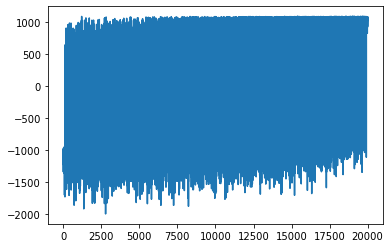

In [76]:
#Plotting graphs using matplotlib
#plot of total rewards each 1000 episodes
plt.plot(total_rewards)
plt.show()


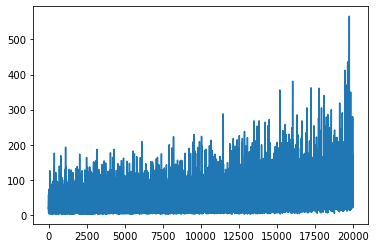

In [77]:
plt.plot(total_moves)
plt.show()

[ 20.  43.  50.  46.  76.  94. 125. 141. 186. 206. 250. 292. 346. 408.
 518. 560. 590. 684. 781. 911.]


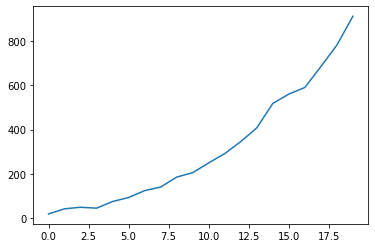

In [78]:

print(wins)
plt.plot(wins)
plt.show()

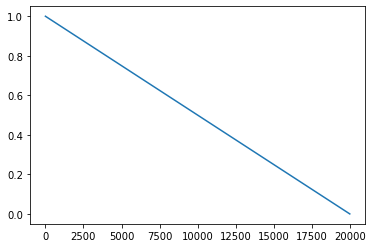

In [79]:

plt.plot(epsilon_values)
plt.show()